Complete notebook available at: https://github.com/ai4up/ufo-prediction/blob/main/demo/demo.ipynb

## Motivation

Building attributes such as building height, type, and construction year are not available for all buildings in EUBUCCO. However, for many prospective use cases of the dataset, such as energy modeling, the building attributes are of high importance. This notebook shows how the available building footprints can be used to estimate missing building attributes with supervised machine learning.

In [1]:
# -.-|m { input: false }

# standard libs
import os
import sys
import logging
import gc

# project lib
PROJECT_SRC_PATH = os.path.join( '/workspace/workspace/ufo-prediction', 'src')
sys.path.append(PROJECT_SRC_PATH)

import visualizations
from prediction_age import AgePredictor, AgeClassifier, AgePredictorComparison
import preprocessing as pp
import dataset

# external libs
import numpy as np
import pandas as pd
import geopandas as gpd
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-4oqzvczl because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# -.-|m { input: false }

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

## Data

Demo sample of ~20k buildings for Spain, ~50k for France, and 170k for the Netherlands. All 117 urban form features, lat lon, as well as some auxiliary attributes like city name, neighborhood, building type, etc. are included.

The demo samples are stored using Git Large File Storage (LFS). To download them explicitly use:

In [3]:
# # When loading ufo data
# #DATA_DIR = '.'
# current_directory = os.getcwd()
# print(current_directory)

# path_data_NLD = os.path.join('/workspace/workspace/ufo-prediction', 'demo', 'df-NLD.pkl')
# path_data_FRA = os.path.join('/workspace/workspace/ufo-prediction', 'demo', 'df-FRA.pkl')
# path_data_ESP = os.path.join('/workspace/workspace/ufo-prediction', 'demo', 'df-ESP.pkl')
# print(path_data_NLD)



/workspace
/workspace/workspace/ufo-prediction/demo/df-NLD.pkl


In [4]:
# df = pd.read_pickle(path_data_NLD)

In [3]:
path_data_RCA = os.path.join(dataset.DATA_DIR, 'rca-ufo-merge_ALL.csv')
df = pd.read_csv(path_data_RCA, encoding='latin1', low_memory=False)

In [4]:
df_temp = df.drop(dataset.RCA_FEATURES_SUB, axis=1)


In [5]:
df_temp2 = df_temp.drop(dataset.RCA_FEATURES_EXTRA, axis=1)

In [6]:
print(df_temp2.columns.to_list())

['Status_tx', 'TransType_tx', 'country_left', 'Main Type', 'SubType', 'DealQualifyer', 'Excess_Land_Potential_fg', 'CMBS_fg', 'Deal5M_fg', 'Deal10M_fg', 'EligibleForVolume_fg', 'EligibleForPPU_fg', 'EligibleForCapRates_fg', 'Active_fg', 'BuyerObjective', 'BuyerCapGroup1', 'BuyerCapType1', 'PropertyName', 'Region', 'State_cd', 'RCA_Metros_tx', 'SellerCapGroup1', 'SellerCapType1', 'County_nm', 'RCA_Markets_tx', 'Leaseback_fg', 'City_tx', 'CBD_fg', 'Zip_cd', 'BuyerCountry', 'BuyerName1', 'Address_tx', 'SellerName1', 'SellerCountry', 'Tenancy_tx', 'source_file', 'dist_to_closest_int', 'av_footprint_area_within_buffer_100', 'street_betweeness_global_max_within_buffer_500', 'av_elongation_within_buffer_500', 'std_building_footprint_city', 'block', 'blocks_2_to_4', 'street_closeness_500_av_within_buffer_500', 'street_width_std_within_buffer_100', 'av_footprint_area_within_buffer_500', 'street_length_total_within_buffer_500', 'BlockConvexity', 'buildings_within_buffer_500', 'StdBlockFootprintA

In [7]:
df_dropped = df_temp2.drop(dataset.RCA_FEATURES_SUBCAT, axis=1)

In [8]:
print(df_dropped.columns.to_list())


['source_file', 'dist_to_closest_int', 'av_footprint_area_within_buffer_100', 'street_betweeness_global_max_within_buffer_500', 'av_elongation_within_buffer_500', 'std_building_footprint_city', 'block', 'blocks_2_to_4', 'street_closeness_500_av_within_buffer_500', 'street_width_std_within_buffer_100', 'av_footprint_area_within_buffer_500', 'street_length_total_within_buffer_500', 'BlockConvexity', 'buildings_within_buffer_500', 'StdBlockFootprintArea', 'street_closeness_global_closest_street', 'std_block_footprint_area_within_buffer_100', 'street_based_block_std_orientation_inter_buffer_100', 'street_length_std_within_buffer_100', 'AvBlockFootprintArea', 'std_block_length_within_buffer_100', 'street_betweeness_global_av_within_buffer_500', 'street_based_block_std_area_inter_buffer_500', 'street_length_closest_street', 'Elongation', 'age_right', 'BlockLength', 'street_closeness_500_closest_street', 'street_length_total_within_buffer_100', 'street_based_block_number_inter_buffer_100', 's

## Prediction

In [9]:
xgb_model_params = {'tree_method': 'hist', 
                    # 'n_estimators': 500
                    }
xgb_hyperparams = {
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 500,
    'colsample_bytree': 0.5,
    'subsample': 1.0,
}

### Regression

2024-01-22 13:39:22,894 | INFO : Dataset length: 6873
2024-01-22 13:39:22,899 | INFO : Dataset allocated memory: 7 MB
2024-01-22 13:39:22,905 | INFO : No abort signal received. Continuing... To abort please create workspace/ufo-prediction/metadata/local-c3b0e6f3.abort.
2024-01-22 13:39:22,906 | INFO : Dataset standard deviation: 123.00019306512388
2024-01-22 13:39:22,907 | INFO : Dataset mean age: 1960.0461225083661
2024-01-22 13:39:22,908 | INFO : Training dataset length: 5498
2024-01-22 13:39:22,908 | INFO : Test dataset length: 1375
2024-01-22 13:39:22,927 | INFO : Test dataset standard deviation after preprocessing: 26.984253393662677
2024-01-22 13:39:22,928 | INFO : Test dataset mean age after preprocessing: 1984.1359223300972
2024-01-22 13:39:22,929 | INFO : Training dataset length after preprocessing: 4945
2024-01-22 13:39:22,929 | INFO : Test dataset length after preprocessing: 1236
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn

MAE: 15.19 y
RMSE: 20.65 y
R2: 0.4137
R2: nan
MAPE: nan


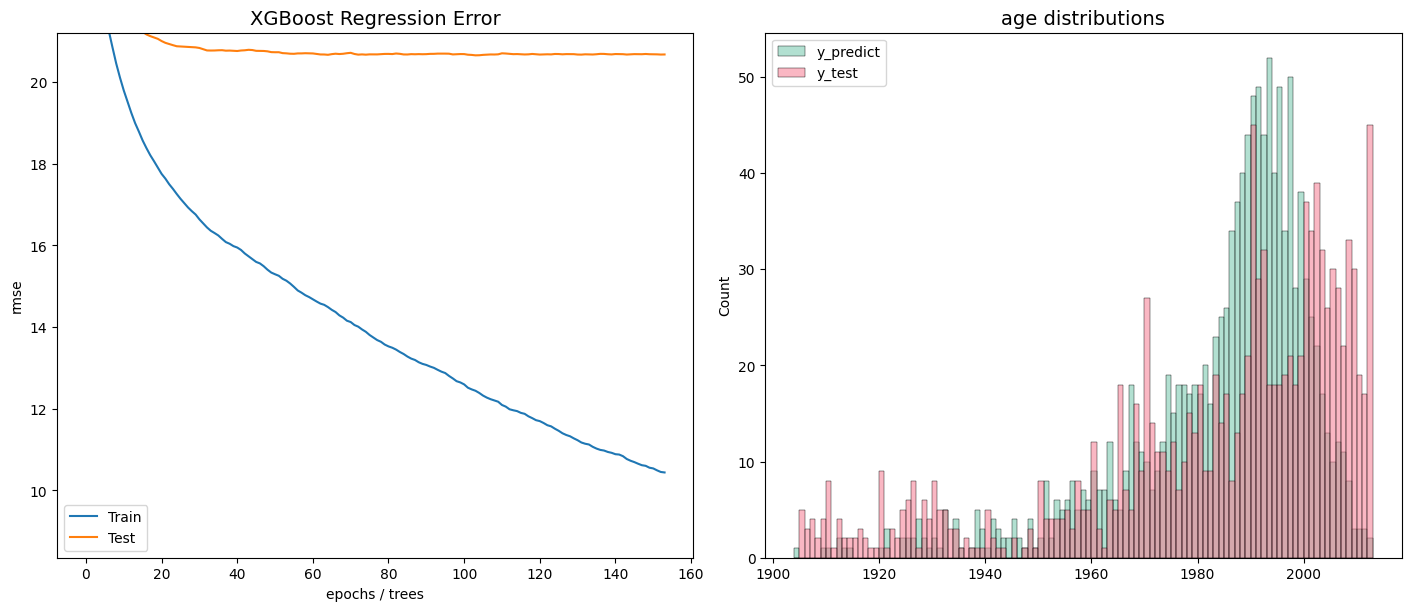

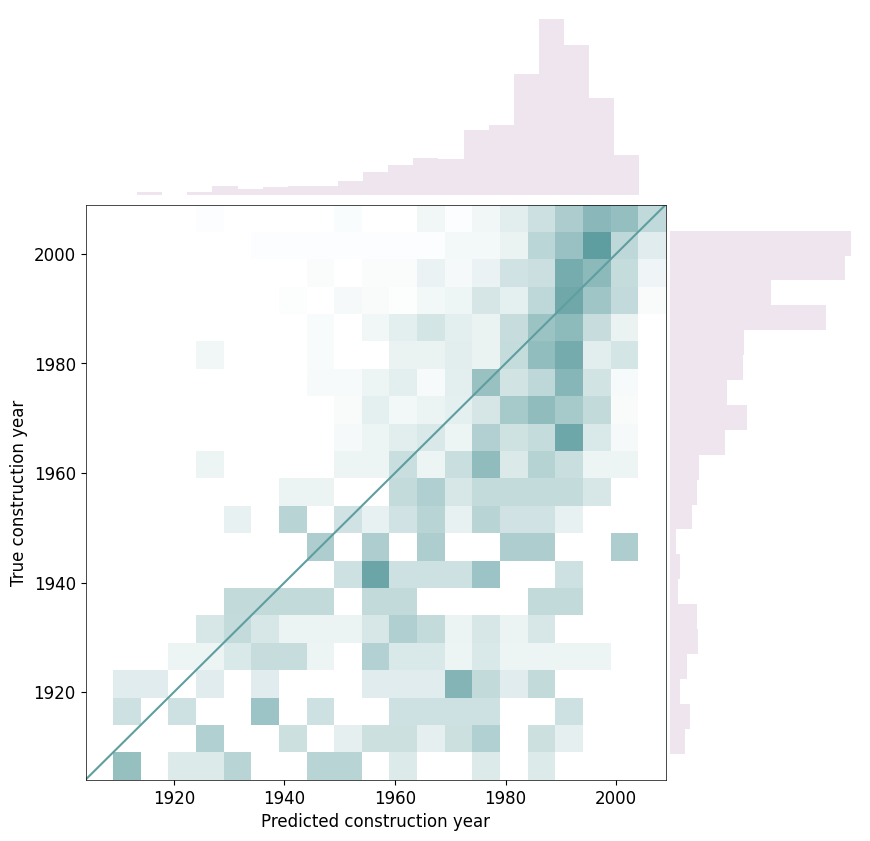

In [10]:
predictor = AgePredictor(
    model=XGBRegressor(**xgb_model_params),
    df=df_dropped,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    early_stopping=True,
    hyperparameters=xgb_hyperparams,
    # preprocessing_stages=[pp.remove_outliers, pp.categorical_to_int_byList, pp.convert_to_double_byList]
    preprocessing_stages=[pp.remove_outliers]
)

predictor.evaluate()


### Classification

2024-01-22 13:45:52,072 | INFO : Generated bins: [1900, 1965, 1975, 1992, 2006, 2015, 2022]
2024-01-22 13:45:52,074 | INFO : Generated bins with the following labels: ['1900-1964', '1965-1974', '1975-1991', '1992-2005', '2006-2014', '2015-2021']
2024-01-22 13:45:52,088 | INFO : Dataset length: 6873
2024-01-22 13:45:52,094 | INFO : Dataset allocated memory: 10 MB
2024-01-22 13:45:52,105 | INFO : No abort signal received. Continuing... To abort please create workspace/ufo-prediction/metadata/local-e4b05e34.abort.
2024-01-22 13:45:52,105 | INFO : Training dataset length: 5498
2024-01-22 13:45:52,106 | INFO : Test dataset length: 1375
2024-01-22 13:45:52,107 | INFO : Test cities: ['Ã\x83Â\x89cully' 'Zwolle' 'Madrid' 'Arnhem' 'Aalten' 'Haarlemmermeer'
 'Nantes' 'Zoetermeer' 'Pornic' 'Rotterdam' 'Viladecavalls'
 'Thorigny-sur-Marne' 'Reus' 'Almere' 'Amsterdam' 'Montrouge'
 'Boulogne-Billancourt' "'s-Gravenhage" 'Eindhoven' 'Barcelona'
 'Groningen' 'Rivas-Vaciamadrid' 'La Garenne-Colombes' 'H

2024-01-22 13:45:52,127 | INFO : age_right attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2024-01-22 13:45:52,134 | INFO : age_right attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2024-01-22 13:45:52,151 | INFO : Training dataset length after preprocessing: 4945
2024-01-22 13:45:52,151 | INFO : Test dataset length after preprocessing: 1236
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Classification report:
               precision    recall  f1-score  support
1900-1964      0.549801  0.638889  0.591006      216
1965-1974      0.312500  0.196850  0.241546      127
1975-1991      0.419014  0.431159  0.425000      276
1992-2005      0.487179  0.523416  0.504648      363
2006-2014      0.442308  0.446602  0.444444      206
2015-2021      0.130435  0.062500  0.084507       48
accuracy       0.458738  0.458738  0.458738        0
macro avg      0.390206  0.383236  0.381859     1236
weighted avg   0.443620  0.458738  0.448570     1236
Cohen’s kappa: 0.3106
Matthews correlation coefficient (MCC): 0.3112


FixedFormatter should only be used together with FixedLocator


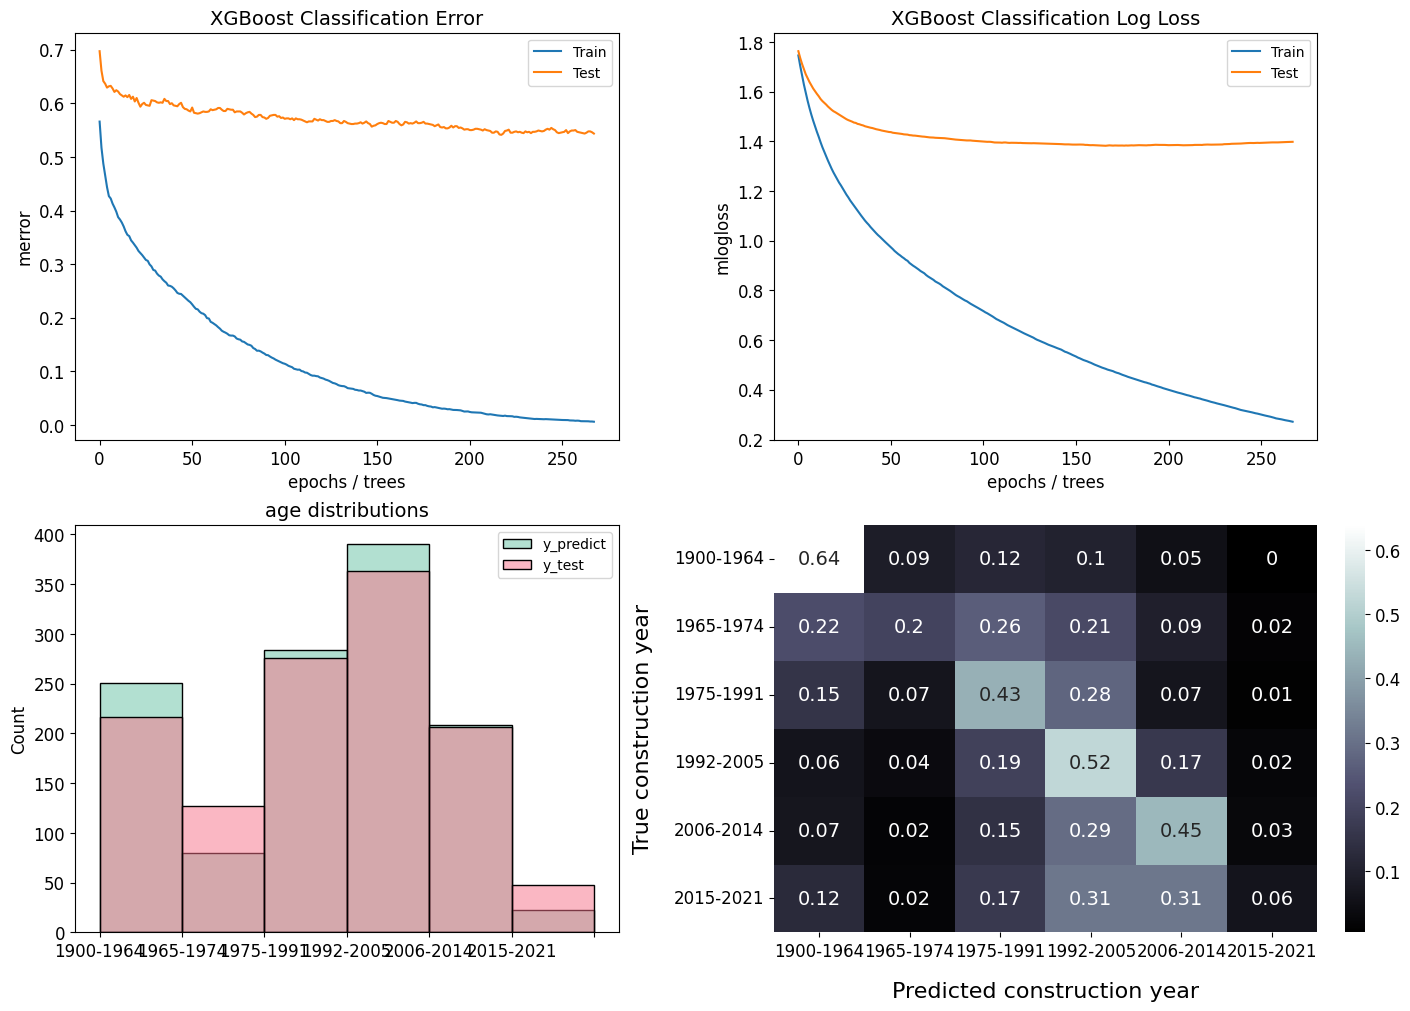

In [11]:
tabula_nl_bins = [1900, 1965, 1975, 1992, 2006, 2015, 2022]
equally_sized_bins = (1900, 2020, 10)

classifier = AgeClassifier(
    model=XGBClassifier(**xgb_model_params),
    df=df,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    mitigate_class_imbalance=True,
    # bin_config=equally_sized_bins,
    bins=tabula_nl_bins,
)
classifier.evaluate()

### Country and generalization comparison

The `AgePredictorComparison` faciliates comparisons between differently configured training runs, for example to compare the prediction performance between countries, cross-validation strategies, oversampling strategies or any other preprocessing steps.

In [21]:
comparison_config = {
    'Spain': {'df': path_data_ESP},
    'France': {'df': path_data_FRA},
    'Netherlands': {'df': path_data_NLD},
}

grid_comparison_config = {
    'random-cv': {'cross_validation_split': pp.cross_validation},
    'neighborhood-cv': {'cross_validation_split': pp.neighborhood_cross_validation},
    'city-cv': {'cross_validation_split': pp.city_cross_validation},
}

comparison = AgePredictorComparison(
    exp_name='demo',
    model=XGBRegressor(**xgb_model_params),
    df=None,
    frac=0.5,
    cross_validation_split=None,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    compare_feature_importance=False,
    compare_classification_error=False,
    include_baseline=False,
    save_results=False,
    garbage_collect_after_training=True,
    comparison_config=comparison_config,
    grid_comparison_config=grid_comparison_config,
)

results = comparison.evaluate()

2024-01-17 14:50:47,195 | INFO : Starting experiment Spain_random-cv...


2024-01-17 14:53:18,314 | INFO : Dataset length: 4226188
2024-01-17 14:53:18,319 | INFO : Dataset allocated memory: 4385 MB
2024-01-17 14:53:20,237 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs/local-33f2404e.abort.
2024-01-17 14:53:20,256 | INFO : Dataset standard deviation: 48.35942318636823
2024-01-17 14:53:20,263 | INFO : Dataset mean age: 1971.7313162594755
2024-01-17 14:53:20,264 | INFO : Training dataset length: 3380950
2024-01-17 14:53:20,264 | INFO : Test dataset length: 845238
2024-01-17 14:53:33,818 | INFO : Test dataset standard deviation after preprocessing: 25.909066171213233
2024-01-17 14:53:33,820 | INFO : Test dataset mean age after preprocessing: 1980.6306878251494
2024-01-17 14:53:33,821 | INFO : Training dataset length after preprocessing: 3058384
2024-01-17 14:53:33,821 | INFO : Test dataset length after preprocessing: 764264
`early_stopping_rounds` in `fit` method is deprecated for better compatibility

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/workspace/ufo-prediction/demo/df-FRA.pkl'

In [ ]:
results

,name,R2,R2_std,MAE,MAE_std,RMSE,RMSE_std,within_5_years,within_10_years,within_20_years,R2_seed_0
8,Netherlands_city-cv,0.135401,0.0,18.030643,0.0,23.598668,0.0,0.221385,0.392977,0.638903,0.135401
7,France_city-cv,0.187767,0.0,18.645831,0.0,23.772030,0.0,0.176875,0.345911,0.615315,0.187767
6,Spain_city-cv,0.197072,0.0,23.840955,0.0,29.563272,0.0,0.126411,0.247178,0.494357,0.197072
3,Spain_neighborhood-cv,0.198503,0.0,23.779078,0.0,29.536916,0.0,0.129797,0.247178,0.506772,0.198503
5,Netherlands_neighborhood-cv,0.304538,0.0,15.884060,0.0,21.164937,0.0,0.241489,0.444702,0.699700,0.304538
4,France_neighborhood-cv,0.330228,0.0,16.306574,0.0,21.586864,0.0,0.211348,0.408337,0.705209,0.330228
0,Spain_random-cv,0.363164,0.0,20.108252,0.0,26.328608,0.0,0.180587,0.355530,0.592551,0.363164
1,France_random-cv,0.511105,0.0,12.372172,0.0,18.443089,0.0,0.369564,0.593466,0.806340,0.511105
2,Netherlands_random-cv,0.575725,0.0,10.203823,0.0,16.531180,0.0,0.525335,0.695626,0.827052,0.575725


In [ ]:
del comparison, predictor, classifier, results, df, df_temp, df_temp2, df_dropped
gc.collect()